In [45]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import geopandas as gpd
import pandas as pd
import plotly.express as px
import json
import numpy as np
# Process the 'reeds_ba_list' column to expand the sets into individual rows, keeping 'state' intact
from ast import literal_eval

polygons_df = pd.read_csv('/Users/ansonkong/Downloads/NYU_work_repo/resources/US_CAN_MEX_PCA_polygons.csv')
state_to_ba_df = pd.read_csv('/Users/ansonkong/Downloads/NYU_work_repo/resources/state_to_ba_mapping.csv')

# Filter polygons
polygons_df = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Since the instructions for processing the state mapping are a bit unclear,
# Convert the string representation of sets in 'reeds_ba_list' to actual sets
state_to_ba_df['reeds_ba_list'] = state_to_ba_df['reeds_ba_list'].apply(literal_eval)

# Explode the sets into separate rows
exploded_df = state_to_ba_df.explode('reeds_ba_list')[['state','reeds_ba_list']]
polygons_df_filtered = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]
polygons_gdf = gpd.GeoDataFrame(polygons_df_filtered, geometry=gpd.GeoSeries.from_wkt(polygons_df_filtered['WKT']))

# Step 2: Merge exploded_df with polygons_gdf on the 'reeds_ba_list' and 'rb' columns
merged_gdf = polygons_gdf.merge(exploded_df, left_on='rb', right_on='reeds_ba_list')
merged_gdf['country']='USA'
merged_gdf=merged_gdf[['rb','state','country','geometry']]

# Country - Group by 'country' and dissolve to merge geometries
gdf_country = merged_gdf.dissolve(by='country').reset_index()

# State - Group by 'state' and dissolve to merge geometries
gdf_state = merged_gdf.dissolve(by='state').reset_index()

# Subregion (rb) - No need to group since each 'rb' is already unique
gdf_subregion = merged_gdf[['rb', 'geometry']].drop_duplicates()


# Convert each GeoDataFrame to GeoJSON for use in Plotly
geojson_country = json.loads(gdf_country.to_json())
geojson_state = json.loads(gdf_state.to_json())
geojson_subregion = json.loads(gdf_subregion.to_json())
# Initialize the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.Div([
        dcc.Graph(id='usa-map', style={'display': 'inline-block', 'width': '70%'}),
        html.Div([
            dcc.RadioItems(
                id='map-toggle',
                options=[
                    {'label': 'Whole Country', 'value': 'country'},
                    {'label': 'By State', 'value': 'state'},
                    {'label': 'By Subregion', 'value': 'subregion'},
                ],
                value='country',  # Default value
                style={'padding': 20}
            ),
            dcc.Dropdown(id='graph-toggle',value='USA',  multi=True)
        ], style={'display': 'inline-block', 'width': '30%', 'verticalAlign': 'top'}),
    ]),
    html.Div([
        dcc.Graph(id='line-graph'),  # Placeholder for the line graph
    ], style={'paddingTop': 20})
])

@app.callback(
    Output('usa-map', 'figure'),
    Input('map-toggle', 'value')
)


def update_map(toggle_value):
    # Choose the correct DataFrame and title based on toggle_value
    if toggle_value == 'country':
        data = gdf_country
        geojson = geojson_country
        color_column = 'country'
    elif toggle_value == 'state':
        data = gdf_state
        geojson = geojson_state
        color_column = 'state'
    else:  # Assuming 'subregion'
        data = gdf_subregion
        geojson = geojson_subregion
        color_column = 'rb'

    # Use Plotly Express to create the choropleth map with a Mapbox base map
    fig = px.choropleth_mapbox(data, geojson=geojson, 
                               locations=data.index, 
                               color=color_column,
                               mapbox_style="white-bg",
                               zoom=3, center={"lat": 37.0902, "lon": -95.7129},
                               opacity=0.5)

    # Add USGS Imagery base map
    fig.update_layout(
        mapbox_layers=[
            {
                "below": 'traces',
                "sourcetype": "raster",
                "source": [
                    "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
                ]
            }
        ]
    )

    # Update layout for no margin and title
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, title=f"Map by {toggle_value.title()}")

    return fig
@app.callback(
    [Output('graph-toggle', 'options'),
     Output('graph-toggle', 'value')],
    [Input('map-toggle', 'value')]
)
def set_graph_toggle_options(selected_map_view):
    print(f"Selected map view: {selected_map_view}")
    if selected_map_view == 'country':
        # Explicitly return 'USA' as the option
        options = [{'label': 'USA', 'value': 'USA'}]
        value='USA'
    elif selected_map_view == 'state':
        # Example state list; replace with your actual data or method to retrieve states
        state_list = ['California', 'New York', 'Texas', 'Florida', 'Illinois']
        options = [{'label': state, 'value': state} for state in state_list]
        value='New York'
    elif selected_map_view == 'subregion':
        # Generate subregion options from 'p1' to 'p134'
        options = [{'label': f'p{i}', 'value': f'p{i}'} for i in range(1, 135)]
        value='p1'
    print(options)

    return options,value

if __name__ == '__main__':
    app.run_server(debug=True)


Selected map view: country
[{'label': 'USA', 'value': 'USA'}]
Selected map view: country
[{'label': 'USA', 'value': 'USA'}]
Selected map view: country
[{'label': 'USA', 'value': 'USA'}]


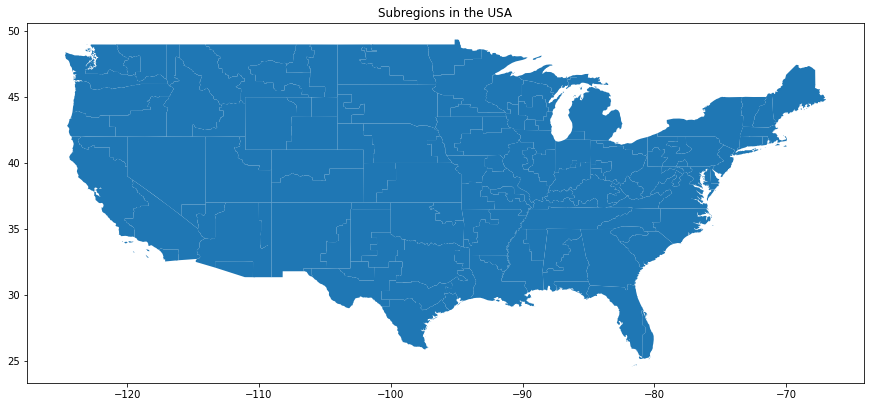

In [11]:
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
import matplotlib.pyplot as plt 
# Load the polygon data
polygons_gdf = pd.read_csv('/Users/ansonkong/Downloads/NYU_work_repo/resources/US_CAN_MEX_PCA_polygons.csv')

# Filter the GeoDataFrame to keep only the specified 'rb' values
polygons_gdf_filtered = polygons_gdf[polygons_gdf['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Convert WKT to a GeoDataFrame for easier plotting
polygons_gdf_filtered = gpd.GeoDataFrame(polygons_gdf_filtered, geometry=gpd.GeoSeries.from_wkt(polygons_gdf_filtered['WKT']))

# Plotting using GeoPandas
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
polygons_gdf_filtered.plot(ax=ax)

# Setting up the plot details
ax.set_title("Subregions in the USA")
plt.show()


In [47]:
current_directory = os.getcwd()

# Construct the path to your resources folder dynamically
resources_path = os.path.join(current_directory, 'resources')

# Now, build the full path to your CSV files
polygons_csv_path = os.path.join(resources_path, 'US_CAN_MEX_PCA_polygons.csv')
state_to_ba_csv_path = os.path.join(resources_path, 'state_to_ba_mapping.csv')
# Finally, use pandas to read the CSV files
polygons_df = pd.read_csv(polygons_csv_path)
state_to_ba_df = pd.read_csv(state_to_ba_csv_path)
# Filter polygons
polygons_df = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Since the instructions for processing the state mapping are a bit unclear,
# Convert the string representation of sets in 'reeds_ba_list' to actual sets
state_to_ba_df['reeds_ba_list'] = state_to_ba_df['reeds_ba_list'].apply(literal_eval)

# Explode the sets into separate rows
exploded_df = state_to_ba_df.explode('reeds_ba_list')[['state','reeds_ba_list']]
polygons_df_filtered = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]
polygons_gdf = gpd.GeoDataFrame(polygons_df_filtered, geometry=gpd.GeoSeries.from_wkt(polygons_df_filtered['WKT']))

# Step 2: Merge exploded_df with polygons_gdf on the 'reeds_ba_list' and 'rb' columns
merged_gdf = polygons_gdf.merge(exploded_df, left_on='rb', right_on='reeds_ba_list')
merged_gdf['country']='USA'
merged_gdf=merged_gdf[['rb','state','country','geometry']]

# Country - Group by 'country' and dissolve to merge geometries
gdf_country = merged_gdf.dissolve(by='country').reset_index()

# State - Group by 'state' and dissolve to merge geometries
gdf_state = merged_gdf.dissolve(by='state').reset_index()

# Subregion (rb) - No need to group since each 'rb' is already unique
gdf_subregion = merged_gdf[['rb', 'geometry']].drop_duplicates()


# Convert each GeoDataFrame to GeoJSON for use in Plotly
geojson_country = json.loads(gdf_country.to_json())
geojson_state = json.loads(gdf_state.to_json())
geojson_subregion = json.loads(gdf_subregion.to_json())
gdf_subregion

,rb,geometry
0,p1,"MULTIPOLYGON (((-122.96072 47.14449, -122.9473..."
1,p10,"MULTIPOLYGON (((-118.39768 32.82017, -118.4245..."
2,p100,"MULTIPOLYGON (((-77.82648 39.13924, -77.86755 ..."
3,p101,"MULTIPOLYGON (((-81.66265 24.58591, -81.68301 ..."
4,p102,"MULTIPOLYGON (((-80.16867 25.84740, -80.13350 ..."
...,...,...
130,p95,"MULTIPOLYGON (((-81.88109 35.18417, -81.04229 ..."
131,p96,"MULTIPOLYGON (((-80.45775 32.37677, -80.48183 ..."
132,p97,"MULTIPOLYGON (((-79.71485 36.54193, -79.50035 ..."
133,p98,"MULTIPOLYGON (((-77.95787 33.89437, -77.97140 ..."


In [43]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import geopandas as gpd
import pandas as pd
import plotly.express as px
import json
import numpy as np
import os
from shapely.geometry import Point
from shapely import wkt
# Process the 'reeds_ba_list' column to expand the sets into individual rows, keeping 'state' intact

current_directory = os.getcwd()

# Construct the path to your resources folder dynamically
data_path = os.path.join(current_directory, 'web_page_data')


# Define paths for the GeoJSON files
country_geojson_path = os.path.join(data_path, 'country_centroids.csv')
state_geojson_path = os.path.join(data_path, 'state_centroids.csv')
rb_geojson_path = os.path.join(data_path, 'rb_centroids.csv')


# Use pandas to read the CSV files
country_centroids_df = pd.read_csv(country_geojson_path)
state_centroids_df = pd.read_csv(state_geojson_path)
rb_centroids_df = pd.read_csv(rb_geojson_path)

# Function to convert a DataFrame with 'lon' and 'lat' columns to a GeoDataFrame
def df_to_gdf(df):
    # Create a GeoSeries from the 'lon' and 'lat' columns
    geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    return gdf

# Convert the DataFrames to GeoDataFrames
gdf_country_centroids = df_to_gdf(country_centroids_df)
gdf_state_centroids = df_to_gdf(state_centroids_df)
gdf_rb_centroids = df_to_gdf(rb_centroids_df)
# Read geometries and centroids GeoJSON files using GeoPandas
# Paths to the CSV files
country_geometry_path = os.path.join(data_path, 'country.csv')
state_geometry_path = os.path.join(data_path, 'state.csv')
rb_geometry_path = os.path.join(data_path, 'rb.csv')

# Read CSV files
df_country = pd.read_csv(country_geometry_path)
df_state = pd.read_csv(state_geometry_path)
df_rb = pd.read_csv(rb_geometry_path)

# # Convert WKT strings to geometrical objects
# df_country['geometry'] = df_country['geometry'].apply(wkt.loads)
# df_state['geometry'] = df_state['geometry'].apply(wkt.loads)
# df_rb['geometry'] = df_rb['geometry'].apply(wkt.loads)

# Transform DataFrames into GeoDataFrames
gdf_country = gpd.GeoDataFrame(df_country, geometry=gpd.GeoSeries.from_wkt(df_country['WKT'])).reset_index()
gdf_state  = gpd.GeoDataFrame(df_state , geometry=gpd.GeoSeries.from_wkt(df_state['WKT'])).reset_index()
gdf_subregion  = gpd.GeoDataFrame(df_rb , geometry=gpd.GeoSeries.from_wkt(df_rb['WKT'])).drop_duplicates()

gdf_country = gdf_country[['country','geometry']]
gdf_state = gdf_state[['state','geometry']]
gdf_subregion['subregion']=gdf_subregion['rb']
gdf_subregion=gdf_subregion[['subregion','geometry']]
# Convert each GeoDataFrame to GeoJSON for use in Plotly
geojson_country = json.loads(gdf_country.to_json())
geojson_state = json.loads(gdf_state.to_json())
geojson_subregion = json.loads(gdf_subregion.to_json())
gdf_subregion 

,subregion,geometry
0,p1,"MULTIPOLYGON (((-13687924.240 5965691.032, -13..."
1,p10,"MULTIPOLYGON (((-13179969.927 3871459.308, -13..."
2,p100,"MULTIPOLYGON (((-8663603.907 4741636.251, -866..."
3,p101,"MULTIPOLYGON (((-9090644.389 2824968.524, -909..."
4,p102,"MULTIPOLYGON (((-8924334.972 2980193.438, -892..."
...,...,...
129,p95,"MULTIPOLYGON (((-9114960.996 4188937.632, -902..."
130,p96,"MULTIPOLYGON (((-8956515.670 3812869.838, -895..."
131,p97,"MULTIPOLYGON (((-8873816.772 4375448.743, -884..."
132,p98,"MULTIPOLYGON (((-8678230.449 4014627.319, -867..."


In [46]:
gdf_subregion2==gdf_subregion

,rb,geometry
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
130,True,True
131,True,True
132,True,True
133,True,True


In [32]:
# Get the current directory where your script is running
current_directory = os.getcwd()

# Construct the path to your resources folder dynamically
data_path = os.path.join(current_directory, 'web_page_data')


# Define paths for the GeoJSON files
country_geojson_path = os.path.join(data_path, 'country_centroids.csv')
state_geojson_path = os.path.join(data_path, 'state_centroids.csv')
rb_geojson_path = os.path.join(data_path, 'rb_centroids.csv')


# Use pandas to read the CSV files
country_centroids_df = pd.read_csv(country_geojson_path)
state_centroids_df = pd.read_csv(state_geojson_path)
rb_centroids_df = pd.read_csv(rb_geojson_path)

# Function to convert a DataFrame with 'lon' and 'lat' columns to a GeoDataFrame
def df_to_gdf(df):
    # Create a GeoSeries from the 'lon' and 'lat' columns
    geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    return gdf

# Convert the DataFrames to GeoDataFrames
gdf_country_centroids = df_to_gdf(country_centroids_df)
gdf_state_centroids = df_to_gdf(state_centroids_df)
gdf_rb_centroids = df_to_gdf(rb_centroids_df)
# Read geometries and centroids GeoJSON files using GeoPandas
# Paths to the CSV files
country_geometry_path = os.path.join(data_path, 'country.csv')
state_geometry_path = os.path.join(data_path, 'state.csv')
rb_geometry_path = os.path.join(data_path, 'rb.csv')

# Read CSV files
df_country = pd.read_csv(country_geometry_path)
df_state = pd.read_csv(state_geometry_path)
df_rb = pd.read_csv(rb_geometry_path)

# Transform DataFrames into GeoDataFrames
gdf_country = gpd.GeoDataFrame(df_country, geometry=gpd.GeoSeries.from_wkt(df_country['WKT'])).reset_index()
gdf_state  = gpd.GeoDataFrame(df_state , geometry=gpd.GeoSeries.from_wkt(df_state['WKT'])).reset_index()
gdf_subregion  = gpd.GeoDataFrame(df_rb , geometry=gpd.GeoSeries.from_wkt(df_rb['WKT'])).drop_duplicates()
gdf_country

,index,WKT,country,geometry
0,0,MULTIPOLYGON (((-10874003.9831 3167878.6467999...,USA,"MULTIPOLYGON (((-10874003.983 3167878.647, -10..."


In [30]:
gdf_country


,index,WKT,country,geometry
0,0,MULTIPOLYGON (((-10874003.9831 3167878.6467999...,USA,"MULTIPOLYGON (((-10874003.983 3167878.647, -10..."


In [31]:
gdf_country2

,country,geometry,rb,state
0,USA,"MULTIPOLYGON (((-97.68284 27.35487, -97.66907 ...",p1,Washington


In [23]:
from deepdiff import DeepDiff

difference = DeepDiff(geojson_country2, geojson_country, ignore_order=True)
print(difference)


{'values_changed': {"root['features'][0]": {'new_value': {'id': '0', 'type': 'Feature', 'properties': {'index': 0, 'WKT': 'MULTIPOLYGON (((-10874003.9831 3167878.646799995, -10872471.3462 3159306.568899989, -10867898.8561 3154101.027000001, -10860068.1431 3152621.337899997, -10845471.8972 3156159.809600005, -10848166.9144 3139809.938400006, -10853331.0018 3134216.592900011, -10850237.56469999 3123735.225900008, -10858167.4211 3123192.978499996, -10860256.6209 3119607.047200007, -10858954.8353 3111595.504099996, -10861417.7719 3104466.451100008, -10853896.3027 3097263.394500004, -10850194.8468 3090699.220899996, -10845599.5865 3066574.886799994, -10846063.4043 3059172.220099997, -10848245.9804 3055364.342599995, -10846503.3308 3050848.277600006, -10843083.8674 3049457.422600001, -10843845.3146 3046398.393699999, -10842128.0087 3043510.077000007, -10837124.1199 3040084.036299997, -10833744.7938 3026402.4747, -10831249.94360001 3023875.147300004, -10831787.75 3019215.331399995, -10829282.

In [16]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import geopandas as gpd
import pandas as pd
import plotly.express as px
import json
import numpy as np
import os
from geopandas import GeoDataFrame, points_from_xy
c

/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_65722/1383791099.py:49: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = merged_gdf.dissolve(by='country')['geometry'].centroid
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_65722/1383791099.py:57: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = merged_gdf.dissolve(by='state')['geometry'].centroid
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_65722/1383791099.py:65: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = merged_gdf.dissolve(by='rb')['geometry'].centr

In [13]:
gdf_country

,country,geometry,rb,state
0,USA,MULTIPOLYGON (((-10874003.9831 3167878.6467999...,p1,Washington


In [54]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import geopandas as gpd
import pandas as pd
import plotly.express as px
import json
import numpy as np
import os
from shapely.geometry import Point
from shapely import wkt
# Process the 'reeds_ba_list' column to expand the sets into individual rows, keeping 'state' intact
from ast import literal_eval
# Get the current directory where your script is running
current_directory = os.getcwd()

# Construct the path to your resources folder dynamically
resources_path = os.path.join(current_directory, 'resources')

# Now, build the full path to your CSV files
polygons_csv_path = os.path.join(resources_path, 'US_CAN_MEX_PCA_polygons.csv')
state_to_ba_csv_path = os.path.join(resources_path, 'state_to_ba_mapping.csv')
# Finally, use pandas to read the CSV files
polygons_df = pd.read_csv(polygons_csv_path)
state_to_ba_df = pd.read_csv(state_to_ba_csv_path)
# Filter polygons
polygons_df = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Since the instructions for processing the state mapping are a bit unclear,
# Convert the string representation of sets in 'reeds_ba_list' to actual sets
state_to_ba_df['reeds_ba_list'] = state_to_ba_df['reeds_ba_list'].apply(literal_eval)

# Explode the sets into separate rows
exploded_df = state_to_ba_df.explode('reeds_ba_list')[['state','reeds_ba_list']]
polygons_df_filtered = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]
polygons_gdf = gpd.GeoDataFrame(polygons_df_filtered, geometry=gpd.GeoSeries.from_wkt(polygons_df_filtered['WKT']))

# Step 2: Merge exploded_df with polygons_gdf on the 'reeds_ba_list' and 'rb' columns
merged_gdf = polygons_gdf.merge(exploded_df, left_on='rb', right_on='reeds_ba_list')
merged_gdf['country']='USA'
merged_gdf=merged_gdf[['rb','state','country','geometry']]

# Country - Group by 'country' and dissolve to merge geometries
gdf_country = merged_gdf.dissolve(by='country').reset_index()

# State - Group by 'state' and dissolve to merge geometries
gdf_state = merged_gdf.dissolve(by='state').reset_index()

# Subregion (rb) - No need to group since each 'rb' is already unique
gdf_subregion = merged_gdf[['rb', 'geometry']].drop_duplicates()


# Convert each GeoDataFrame to GeoJSON for use in Plotly
geojson_country = json.loads(gdf_country.to_json())
geojson_state = json.loads(gdf_state.to_json())
geojson_subregion = json.loads(gdf_subregion.to_json())
import json
current_directory= os.path.join(current_directory, 'web_page_data')
# Define file paths for saving
geojson_country_path = os.path.join(current_directory, 'geojson_country.json')
geojson_state_path = os.path.join(current_directory, 'geojson_state.json')
geojson_subregion_path = os.path.join(current_directory, 'geojson_subregion.json')
# Define file paths for saving
gdf_country_path = os.path.join(current_directory, 'gdf_country.gpkg')
gdf_state_path = os.path.join(current_directory, 'gdf_state.gpkg')
gdf_subregion_path = os.path.join(current_directory, 'gdf_subregion.gpkg')

# Save the GeoDataFrames
gdf_country.to_file(gdf_country_path, driver='GPKG')
gdf_state.to_file(gdf_state_path, driver='GPKG')
gdf_subregion.to_file(gdf_subregion_path, driver='GPKG')

# Function to save GeoJSON to a file
def save_geojson(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f)

# Save the GeoJSON data
save_geojson(geojson_country, geojson_country_path)
save_geojson(geojson_state, geojson_state_path)
save_geojson(geojson_subregion, geojson_subregion_path)


In [50]:
import json
current_directory= os.path.join(current_directory, 'web_page_data')
# Define file paths for saving
geojson_country_path = os.path.join(current_directory, 'geojson_country.json')
geojson_state_path = os.path.join(current_directory, 'geojson_state.json')
geojson_subregion_path = os.path.join(current_directory, 'geojson_subregion.json')

# Function to save GeoJSON to a file
def save_geojson(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f)

# Save the GeoJSON data
save_geojson(geojson_country, geojson_country_path)
save_geojson(geojson_state, geojson_state_path)
save_geojson(geojson_subregion, geojson_subregion_path)


In [51]:
# Function to read GeoJSON from a file
def read_geojson(file_path):
    with open(file_path) as f:
        return json.load(f)

# Read the GeoJSON data
geojson_country_read = read_geojson(geojson_country_path)
geojson_state_read = read_geojson(geojson_state_path)
geojson_subregion_read = read_geojson(geojson_subregion_path)


In [52]:
print(geojson_country == geojson_country_read)
print(geojson_state == geojson_state_read)
print(geojson_subregion == geojson_subregion_read)


True
True
True


In [55]:
# Read the GeoDataFrames
gdf_country_read = gpd.read_file(gdf_country_path)
gdf_state_read = gpd.read_file(gdf_state_path)
gdf_subregion_read = gpd.read_file(gdf_subregion_path)


In [56]:
print(gdf_country.shape == gdf_country_read.shape)
print(gdf_state.shape == gdf_state_read.shape)
print(gdf_subregion.shape == gdf_subregion_read.shape)

# Sample a row and compare geometries (example using 'gdf_country')
print(gdf_country.geometry.iloc[0].equals(gdf_country_read.geometry.iloc[0]))


True
True
True
True
